In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import numpy as np
import re
import os

In [17]:
COLUMNS = ['period', 'wifi', 'Stack', 'Mbps']

In [18]:
runs = os.listdir('./formated_data')
experiments = {key: list(group) for key, group in itertools.groupby(runs, key=lambda exp_run: exp_run[:-6])}

In [19]:
import numpy as np
a = np.ones((3, 5))
np.sum(a, axis=1)

array([5., 5., 5.])

In [20]:
print(experiments.keys())

dict_keys(['A1I1M1', 'A1I1M2', 'A1I1M3', 'A1I2M1', 'A1I2M2', 'A1I2M3', 'A2I1M1', 'A2I1M2', 'A2I1M3', 'A2I2M1', 'A2I2M2', 'A2I2M3', 'A3I1M1', 'A3I1M2', 'A3I1M3', 'A3I2M1', 'A3I2M2', 'A3I2M3'])


In [21]:
def change_wifi(df):
    cols_drop = ['period', 'wifi', 'Stack', 'Mbps'] + (['main'] if 'main' in df.columns else [])
    aux = df.drop(cols_drop, axis=1)
    df['wifi'] = df['wifi'].values / np.sum(aux.values, axis=1)
    return df

def recenter_period(df):
    df['period'] = df['period'] - np.min(df['period'])
    return df

In [22]:
all_data = {run: recenter_period(change_wifi(pd.read_csv(f'./formated_data/{run}')))[COLUMNS] for run in runs}

In [23]:
experiments_df = {key: pd.concat([all_data[file_name] for file_name in experiments[key]]) for key in experiments}

In [24]:
experiments_df['A1I1M1']['wifi']

0      0.159888
1      0.155409
2      0.146556
3      0.175447
4      0.180994
         ...   
173    0.211407
174    0.211382
175    0.207058
176    0.207080
177    0.207111
Name: wifi, Length: 1791, dtype: float64

In [25]:
def group_models(experiments):
    groups = {key: [] for key in set([experiment[2:] for experiment in experiments])} 
    for experiment in experiments:
        groups[experiment[2:]].append(experiment)
    return groups

In [26]:
keys_group_by_model = group_models(experiments)
print(keys_group_by_model)

{'I1M3': ['A1I1M3', 'A2I1M3', 'A3I1M3'], 'I2M2': ['A1I2M2', 'A2I2M2', 'A3I2M2'], 'I2M1': ['A1I2M1', 'A2I2M1', 'A3I2M1'], 'I1M1': ['A1I1M1', 'A2I1M1', 'A3I1M1'], 'I2M3': ['A1I2M3', 'A2I2M3', 'A3I2M3'], 'I1M2': ['A1I1M2', 'A2I1M2', 'A3I1M2']}


In [27]:
def plot_time_series(dfs, metric, labels, x_lable, y_lable, title):
    fig, axis = plt.subplots(1, 1, figsize=(16, 9))
    x = np.arange(176)
    x_ticks = np.arange(0, 175, 25)
    colors = ['indianred', 'limegreen', 'royalblue']
    for i, df in enumerate(dfs):
        period_groups = df.groupby('period')
        periods = np.stack([period_groups.get_group(key)[metric].values for key in period_groups.groups.keys()][:176], axis=0)
        median, q1, q3 = np.percentile(periods, [50, 25, 75], axis=1)
        axis.plot(x, median, color=colors[i], label=labels[i])
        axis.fill_between(x, q1, q3, alpha=0.2, color=colors[i], linewidth=None)
    axis.set_xlabel(x_lable, fontsize=20)
    axis.set_ylabel(y_lable, fontsize=20, labelpad=10.0)
    axis.set_xticks(x_ticks)
    axis.set_title(title, fontsize=30, pad=30.0)
    axis.legend(ncol=len(dfs), loc='upper center', borderaxespad=-2, frameon=False)
    axis.grid(color='gainsboro', linestyle=':', linewidth=2)
    axis.set_xlim(left=0, right=175)
    return fig, axis

def plot_stats(experiments_df, metric):
    key_groups = group_models(experiments)
    for exp1, exp2, exp3 in [key_groups[key] for key in key_groups]:
        dfs = [experiments_df[exp1], experiments_df[exp2], experiments_df[exp3]]
        title = 'I1M2'
        labels = [exp1[:2], exp2[:2], exp3[:2]]
        x_lable = 'time'
        y_lable = 'cpu_usage' if metric == 'wifi' else metric
        title = exp1[2:] 
        fig, axis = plot_time_series(dfs, metric, labels, x_lable, y_lable, title)
        fig.savefig(f'./graphs/{title}_{metric}.pdf')

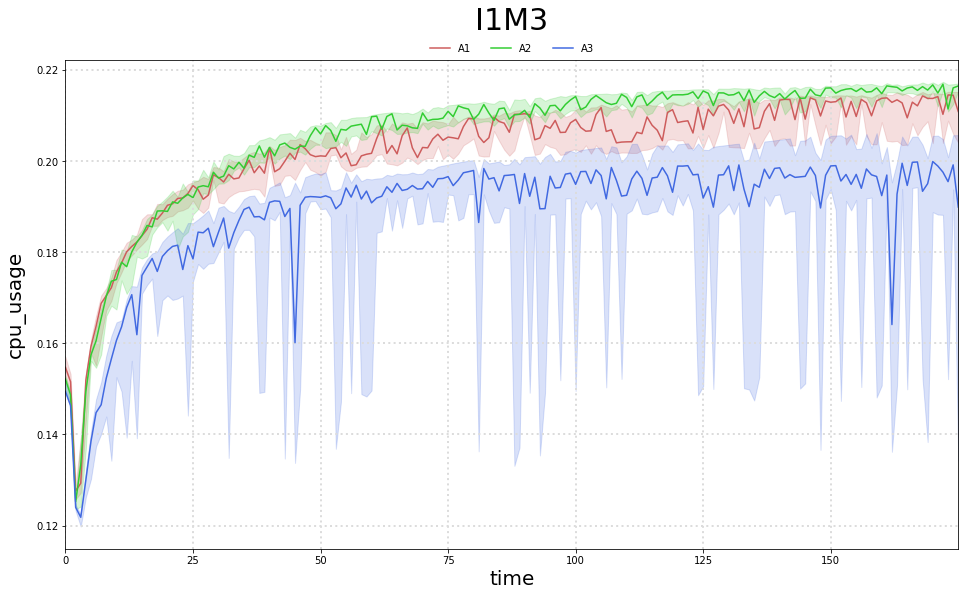

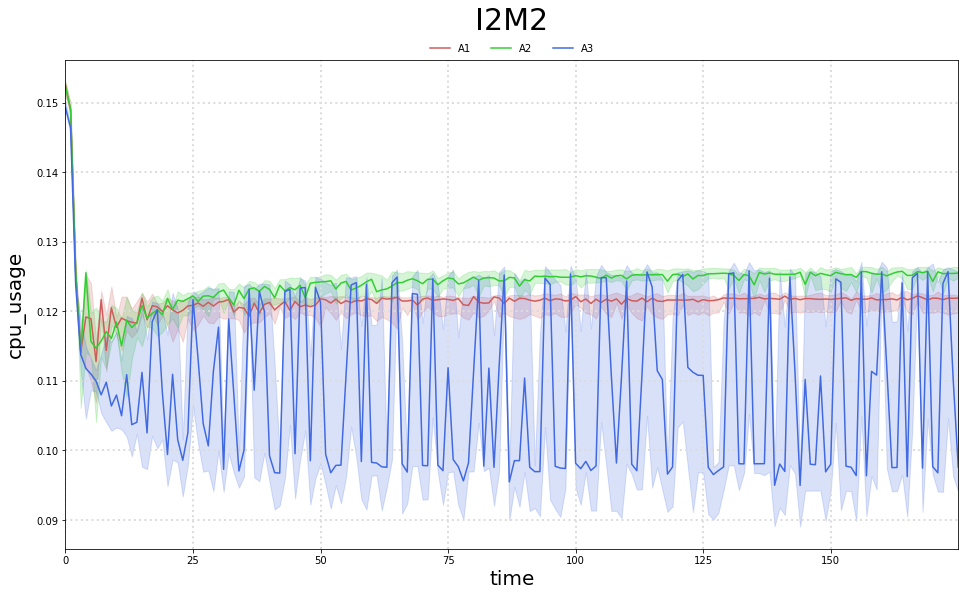

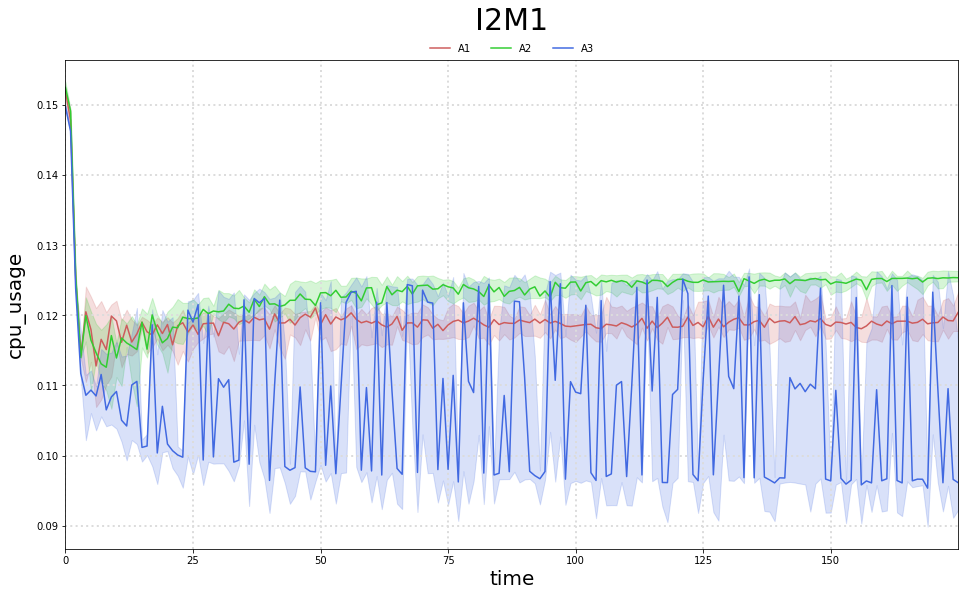

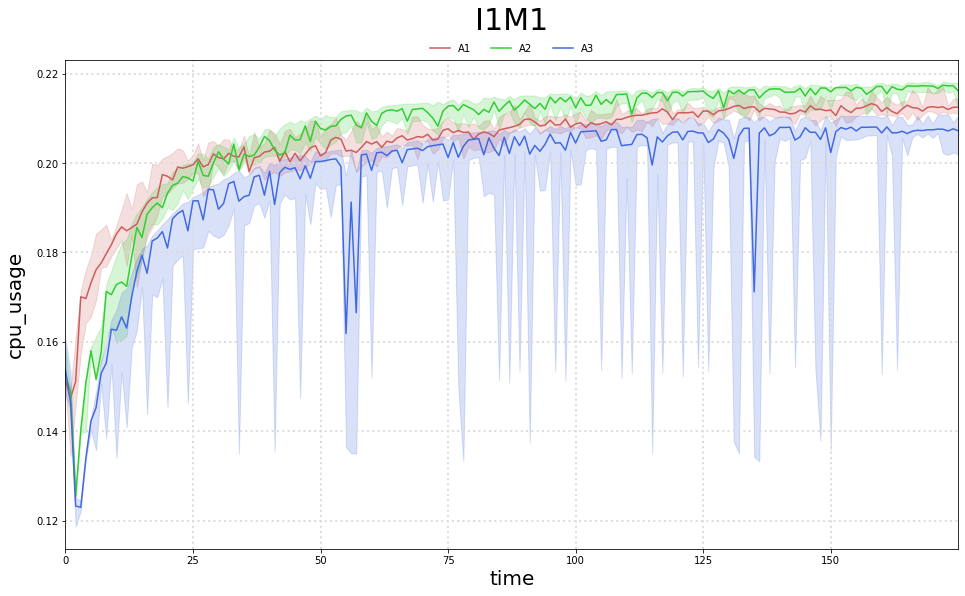

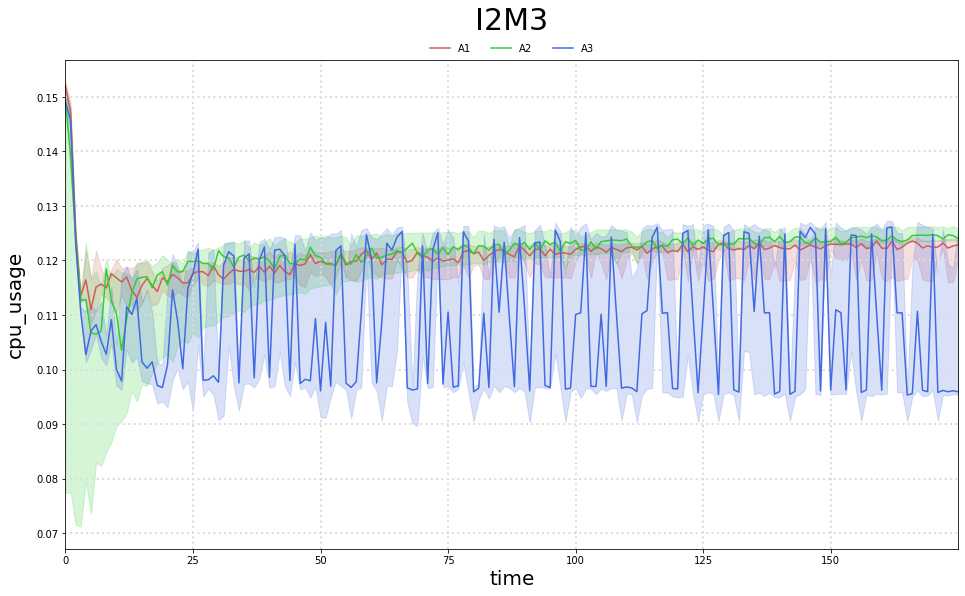

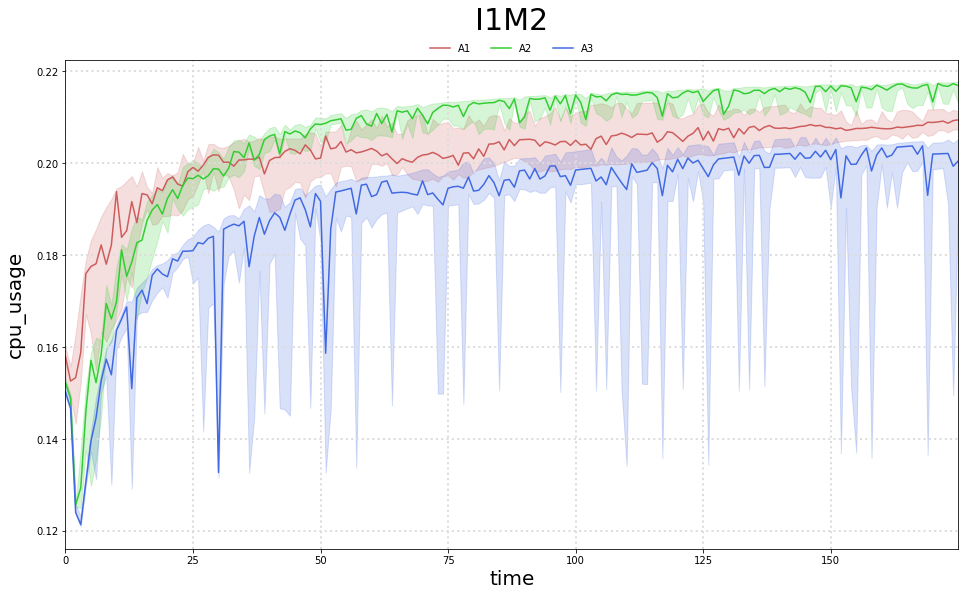

In [28]:
plot_stats(experiments_df, 'wifi')
# 3 x 6
#

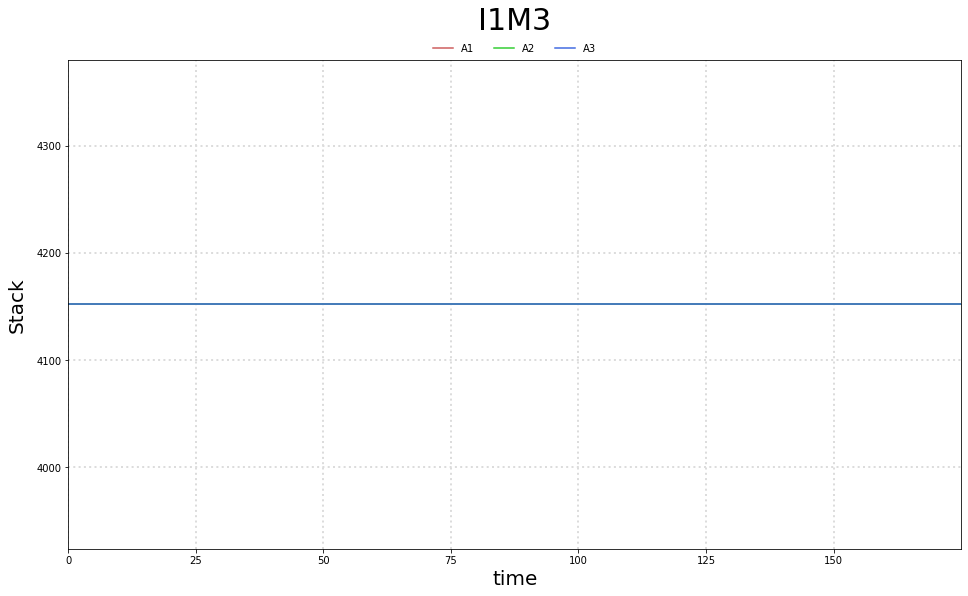

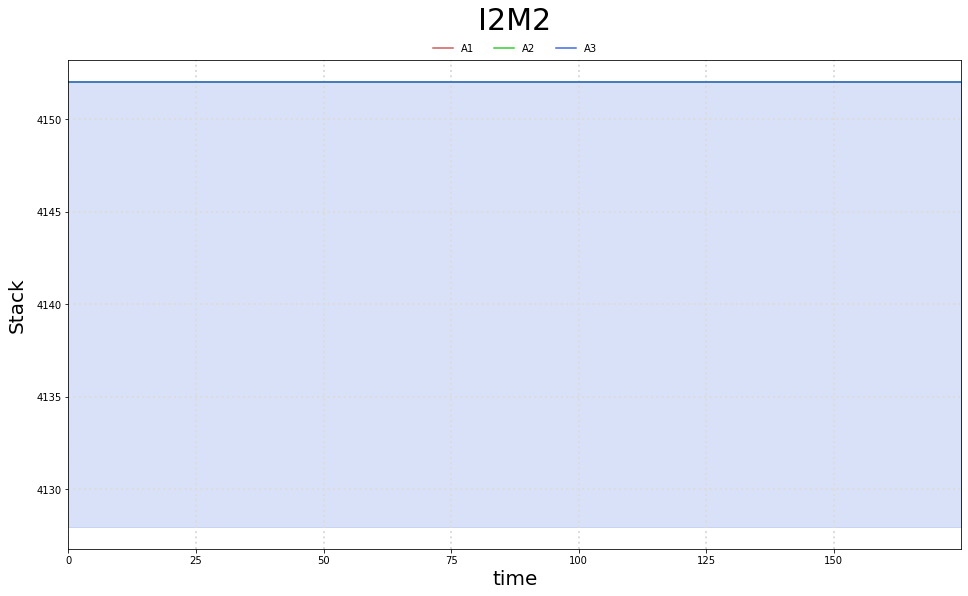

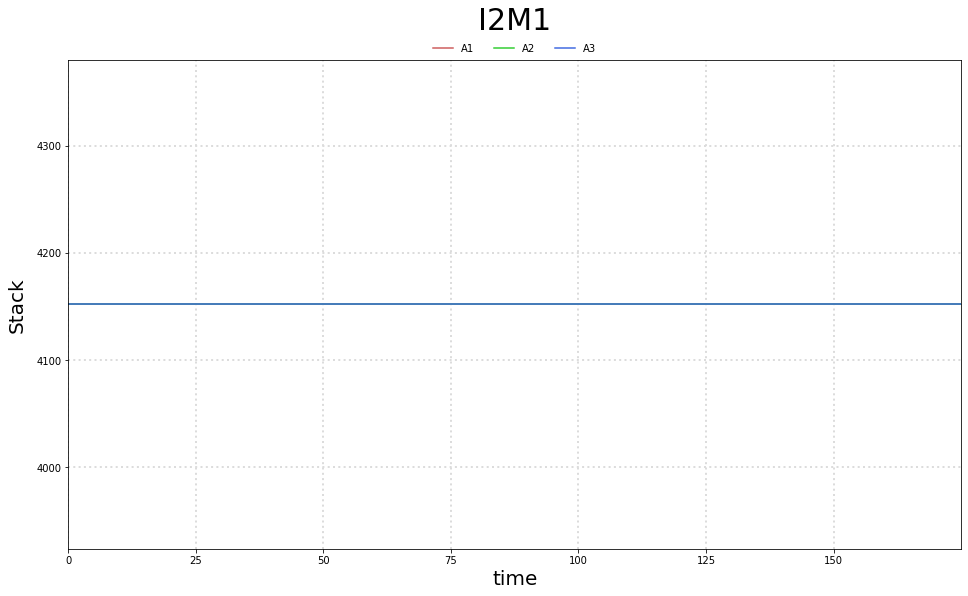

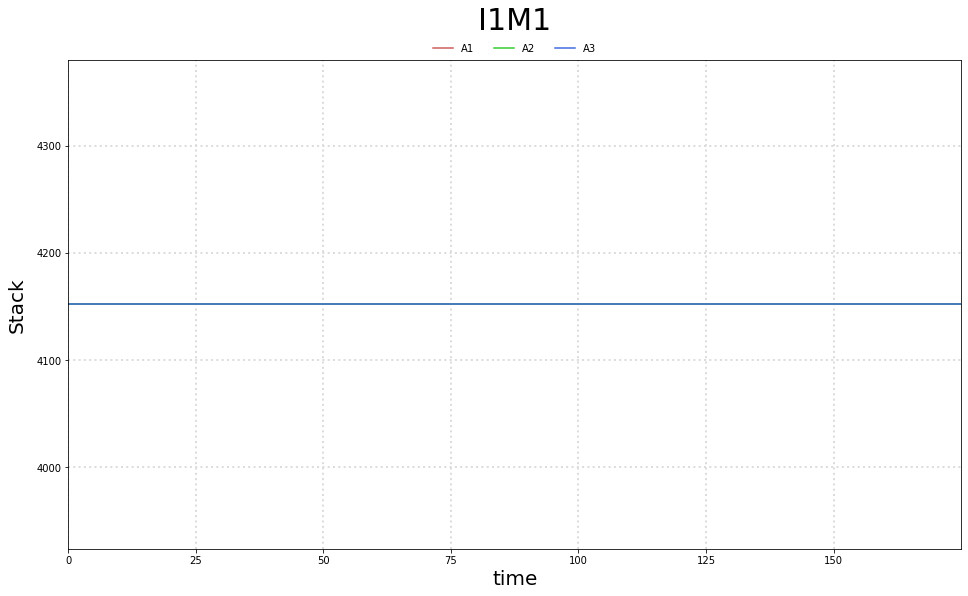

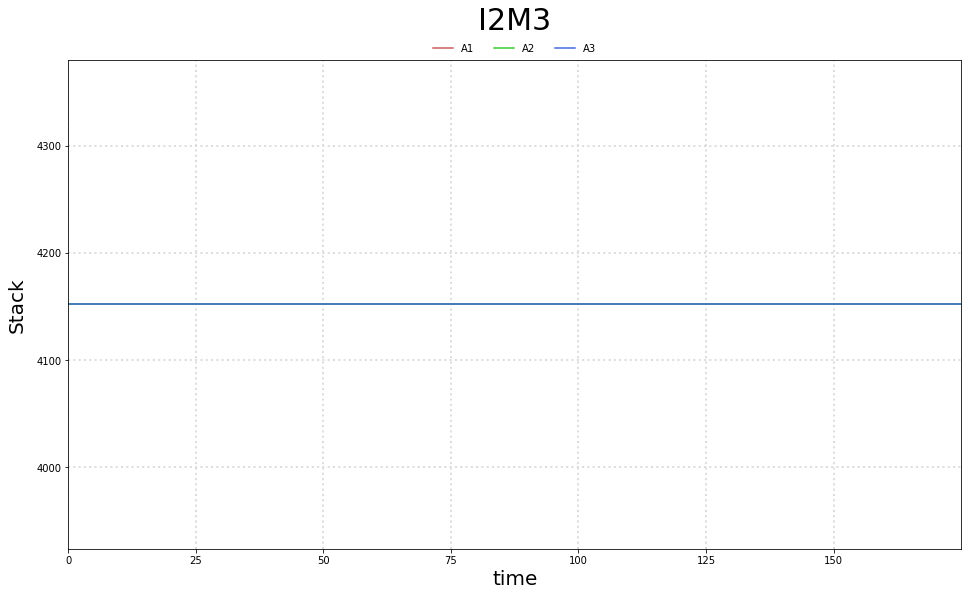

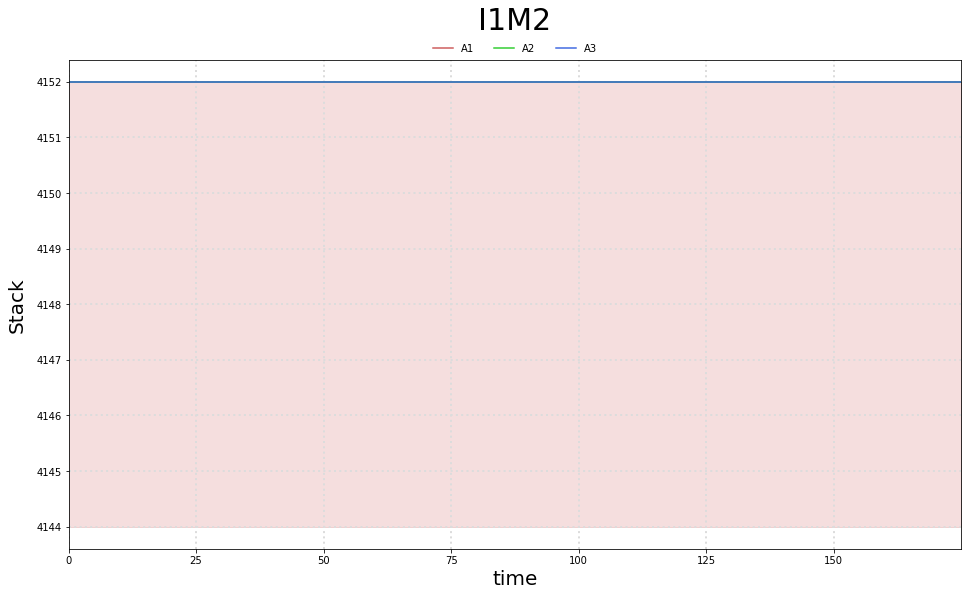

In [29]:
plot_stats(experiments_df, 'Stack')

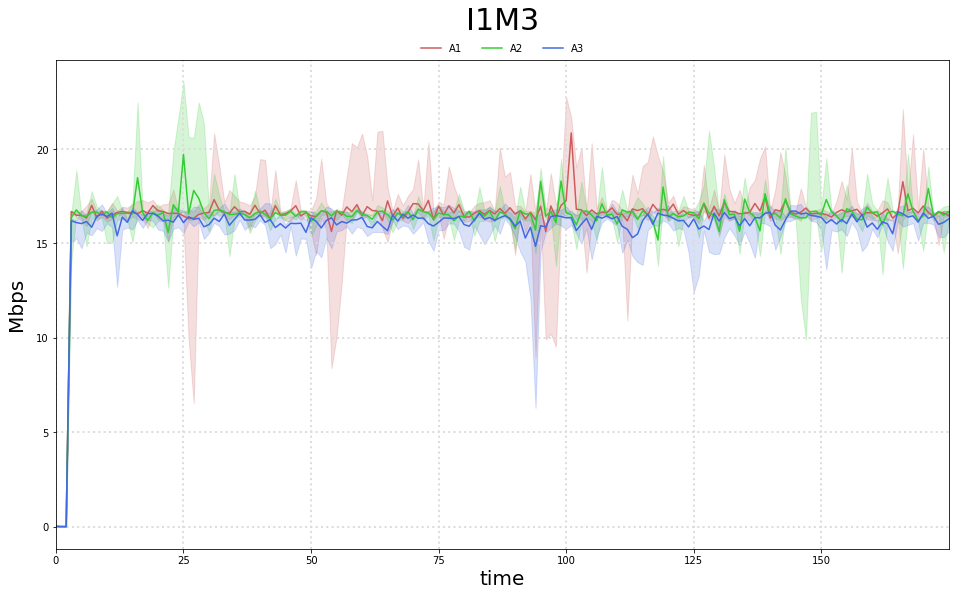

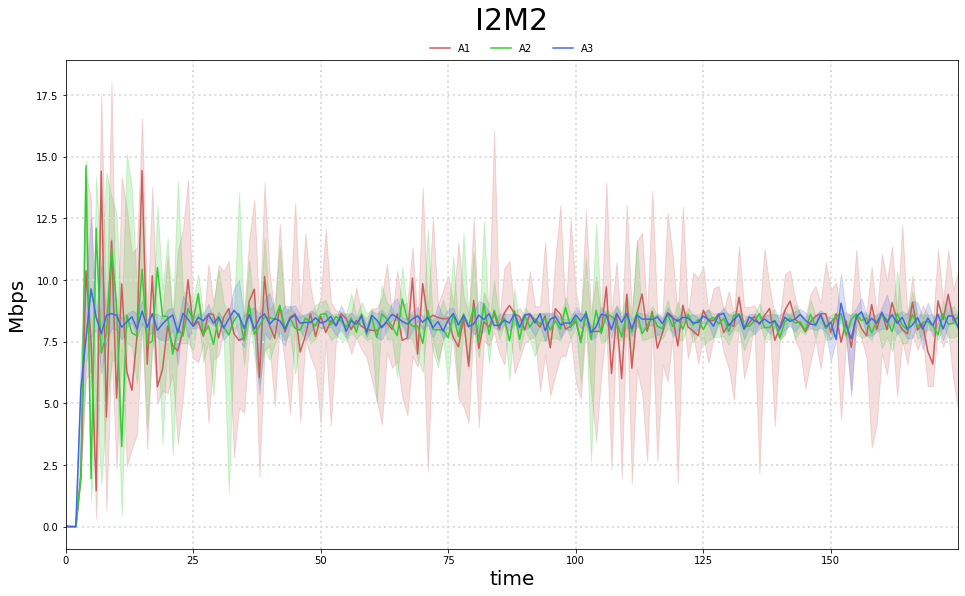

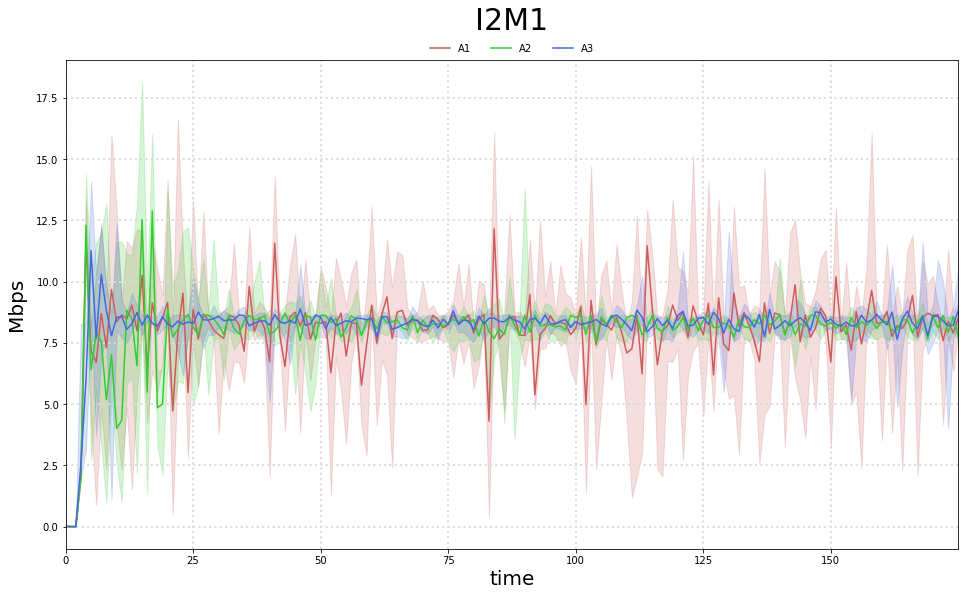

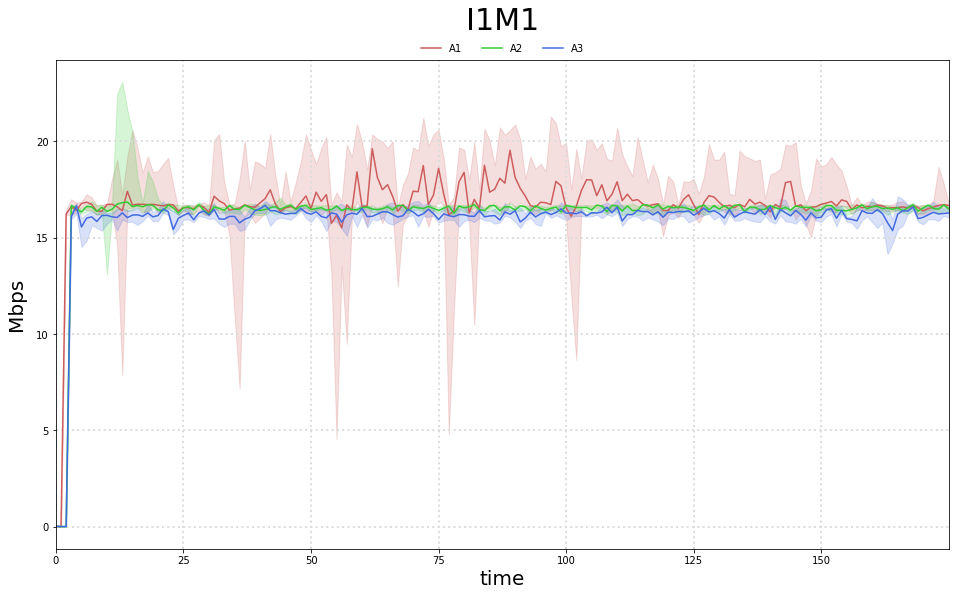

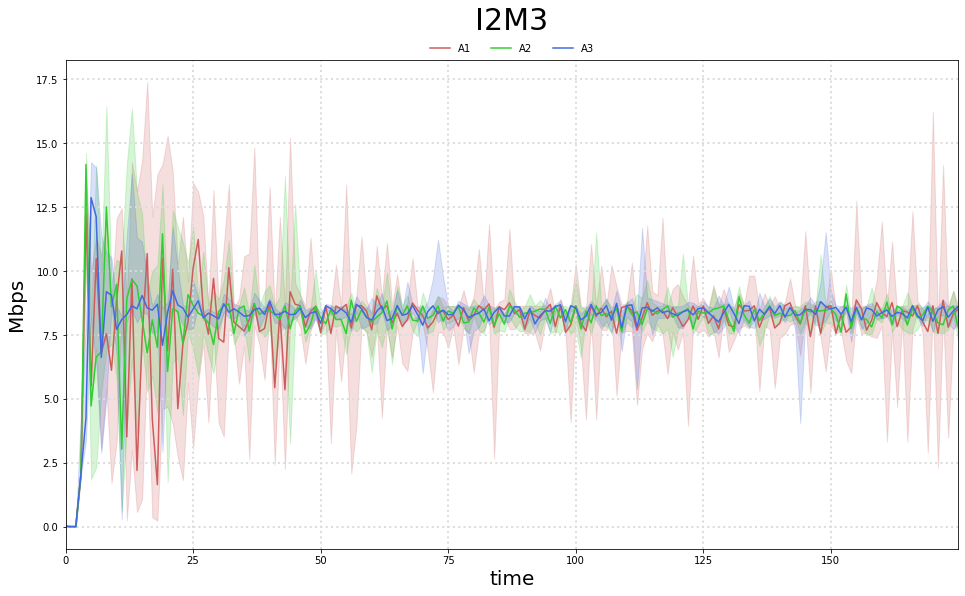

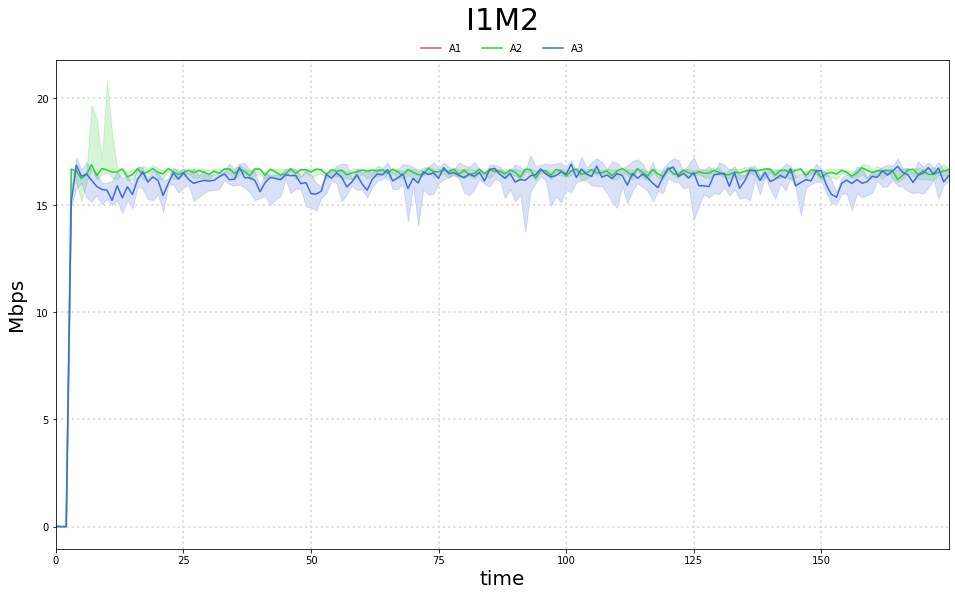

In [30]:
plot_stats(experiments_df, 'Mbps')

In [35]:
factors = [keys_group_by_model['I1M1'], keys_group_by_model['I1M2'], keys_group_by_model['I2M1'], keys_group_by_model['I2M2']]
print(factors)

[['A1I1M1', 'A2I1M1', 'A3I1M1'], ['A1I1M2', 'A2I1M2', 'A3I1M2'], ['A1I2M1', 'A2I2M1', 'A3I2M1'], ['A1I2M2', 'A2I2M2', 'A3I2M2']]


In [47]:
# q0 +q_ax_a + q_bx_b + q_abx_ax_b
# ==================================
#
# i1m1 = q0 - q_a - q_b + q_ab
# i1m2 = q0 + q_a - q_b - q_ab
# i2m1 = q0 - q_a + q_b - q_ab
# i2m2 = q0 + q_a + q_b + q_ab
#
# ==================================
#
# q0   = 1 / 4 ( i1m1 + i1m2 + i2m1 + i2m2)
# q_a  = 1 / 4 (-i1m1 + i1m2 - i2m1 + i2m2)
# q_b  = 1 / 4 (-i1m1 - i1m2 + i2m1 + i2m2)
# q_ab = 1 / 4 ( i1m1 - i1m2 - i2m1 + i2m2)

variation_data = {
    'model': [],
    'A': [],
    'B': [],
    'AB': [],
    'Err': []
}

for i, (i1m1, i1m2, i2m1, i2m2) in enumerate(zip(*factors)):
    df_i1m1, df_i1m2, df_i2m1, df_i2m2 = [experiments_df[i1m1], experiments_df[i1m2], experiments_df[i2m1], experiments_df[i2m1]]
    period_groups_i1m1 = df_i1m1.groupby('period')
    period_groups_i1m2 = df_i1m2.groupby('period')
    period_groups_i2m1 = df_i1m2.groupby('period')
    period_groups_i2m2 = df_i2m2.groupby('period')
    wifis_i1m1 = period_groups_i1m1.get_group(176)['wifi'].values
    wifis_i1m2 = period_groups_i1m2.get_group(176)['wifi'].values
    wifis_i2m1 = period_groups_i2m1.get_group(176)['wifi'].values
    wifis_i2m2 = period_groups_i2m2.get_group(176)['wifi'].values
    wifis = np.stack([wifis_i1m1, wifis_i1m2, wifis_i2m1, wifis_i2m2])
    mean_wifis = np.mean(wifis, axis=1)
    q0   = 1 / 4 * ( mean_wifis[2] + mean_wifis[3] + mean_wifis[0] + mean_wifis[1])
    q_a  = 1 / 4 * (-mean_wifis[2] + mean_wifis[3] - mean_wifis[0] + mean_wifis[1])
    q_b  = 1 / 4 * (-mean_wifis[2] - mean_wifis[3] + mean_wifis[0] + mean_wifis[1])
    q_ab = 1 / 4 * ( mean_wifis[2] - mean_wifis[3] - mean_wifis[0] + mean_wifis[1])
    
    SSE = np.sum(np.square(wifis - np.expand_dims(mean_wifis, axis=-1)))
    SSY = np.sum(np.square(wifis))
    SS0 = 4 * 10 * (q0 ** 2)
    SSA = 4 * 10 * (q_a ** 2)
    SSB = 4 * 10 * (q_b ** 2)
    SSAB = 4 * 10 * (q_ab ** 2)
    SST = SSY - SS0
    variation_data['model'].append(f'A{i}')
    variation_data['A'].append(SSA / SST)
    variation_data['B'].append(SSB / SST)
    variation_data['AB'].append(SSAB / SST)
    variation_data['Err'].append(SSE / SST)
res = pd.DataFrame(variation_data)
print(res)

  model         A         B        AB       Err
0    A0  0.172508  0.172508  0.027539  0.627445
1    A1  0.341734  0.341734  0.310736  0.005795
2    A2  0.181585  0.181585  0.209414  0.427416
